# 0. Import Libraries

In [82]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import sklearn
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD
from torch.utils.data import DataLoader, TensorDataset, Dataset
from scipy.sparse import csr_matrix
from abc import ABC, abstractmethod
import os
from pathlib import Path
import json
import scipy.sparse as sparse
from enum import Enum
import copy

import warnings
warnings.filterwarnings("ignore")
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
ML_PATH = "/kaggle/input/movielens-1m-dataset"
USERS_PATH = ML_PATH + "/users.dat"
MOVIES_PATH = ML_PATH + "/movies.dat"
RATINGS_PATH = ML_PATH + "/ratings.dat"

In [31]:
MODEL_OUTPUT_PATH = "models"
MODEL_INPUT_PATH = "/kaggle/input/movie-lens-1m-models/gts_model_history/model"
HISTORY_OUTPUT_PATH = "history"
HISTORY_INPUT_PATH = "/kaggle/input/movie-lens-1m-models/gts_model_history/history"

# 1. Load Data

In [3]:
users_df = pd.read_csv(USERS_PATH, sep="::", names=['userId', 'gender', 'ageCode', 'occupationCode', 'zipCode'])
age_code_mapping = {1:  "Under 18", 18:  "18-24", 25:  "25-34", 35:  "35-44", 45:  "45-49", 50:  "50-55", 56:  "56+"}
users_df['age'] = users_df['ageCode'].map(age_code_mapping)
occupation_code_mapping = {
    0:  "other",
	1:  "academic/educator",
	2:  "artist",
	3:  "clerical/admin",
	4:  "college/grad student",
	5:  "customer service",
	6:  "doctor/health care",
	7:  "executive/managerial",
	8:  "farmer",
	9:  "homemaker",
	10:  "K-12 student",
	11:  "lawyer",
	12:  "programmer",
	13:  "retired",
	14:  "sales/marketing",
	15:  "scientist",
	16:  "self-employed",
	17:  "technician/engineer",
	18:  "tradesman/craftsman",
	19:  "unemployed",
	20:  "writer"
}
users_df['occupation'] = users_df['occupationCode'].map(occupation_code_mapping)
users_df.head()

,userId,gender,ageCode,occupationCode,zipCode,age,occupation
0,1,F,1,10,48067,Under 18,K-12 student
1,2,M,56,16,70072,56+,self-employed
2,3,M,25,15,55117,25-34,scientist
3,4,M,45,7,02460,45-49,executive/managerial
4,5,M,25,20,55455,25-34,writer


In [4]:
movies_df = pd.read_csv(MOVIES_PATH, sep="::", names=['movieId', 'title', 'genres'], encoding='latin-1')
movies_genre_df = movies_df.copy()
movies_genre_df['genres'] = movies_genre_df['genres'].map(lambda x: x.split("|"))
movies_genre_df = movies_genre_df.explode('genres')
display(movies_df.head())
display(movies_genre_df.head())

,movieId,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


,movieId,title,genres
0,1,Toy Story (1995),Animation
0,1,Toy Story (1995),Children's
0,1,Toy Story (1995),Comedy
1,2,Jumanji (1995),Adventure
1,2,Jumanji (1995),Children's


In [5]:
ratings_df = pd.read_csv(RATINGS_PATH, sep="::", names=['userId', 'movieId', 'rating', 'timestamp'])
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


# 2. Evaluation Split

## 2.A. Random

In [6]:
def random_split(df, user_id_col, movie_id_col, holdout_fraction=0.2):
    test = df.sample(frac=holdout_fraction, replace=False, random_state=42)
    train = df[~df.index.isin(test.index)]
    users_train = train[user_id_col].unique()
    movies_train = train[movie_id_col].unique()
    train_users_count = len(users_train)
    train_movies_count = len(movies_train)
    test_users_count = len(test[user_id_col].unique())
    test_movies_count = len(test[movie_id_col].unique())
    print(f"Train count: {len(train)}")
    print(f"Train users count: {train_users_count}")
    print(f"Train movies count: {train_movies_count}")
    print(f"Test count: {len(test)}")
    print(f"Test users count: {test_users_count}")
    print(f"Test movies count: {test_movies_count}")

    users_train = train[user_id_col].unique()
    movies_train = train[movie_id_col].unique()
    test = test[(test[user_id_col].isin(users_train)) & (test[movie_id_col].isin(movies_train))]
    print("Truncating test users & items invalid for CF completed.")
    print(f"Test count: {len(test)}")
    test_users_count_after = len(test[user_id_col].unique())
    test_movies_count_after = len(test[movie_id_col].unique())
    print(f"Test users count: {test_users_count_after}")
    print(f"{(1- (test_users_count_after/test_users_count))*100:.4f}% of users truncated.")
    print(f"Test movies count: {test_movies_count_after}")
    print(f"{(1- (test_movies_count_after/test_movies_count))*100:.4f}% of movies truncated.")
    return train, test

In [7]:
rnd_train_df, rnd_test_df = random_split(ratings_df, user_id_col='userId', movie_id_col='movieId', holdout_fraction=0.1)

Train count: 900188
Train users count: 6040
Train movies count: 3694
Test count: 100021
Test users count: 5970
Test movies count: 3294
Truncating test users & items invalid for CF completed.
Test count: 100009
Test users count: 5970
0.0000% of users truncated.
Test movies count: 3282
0.3643% of movies truncated.


## 2.B. Leave-One-Out

In [8]:
def leave_one_out_split(df, user_id_col, movie_id_col, holdout_fraction=0.2):
    df['rank'] = df.sort_values(['timestamp'], ascending=True) \
             .groupby(['userId']) \
             .cumcount() + 1
    test = df[df['rank'] == 1]
    train = df[df['rank'] > 1]
    movies_train = train[movie_id_col].unique()
    train_users_count = len(train[user_id_col].unique())
    train_movies_count = len(movies_train)
    test_users_count = len(test[user_id_col].unique())
    test_movies_count = len(test[movie_id_col].unique())
    print(f"Train count: {len(train)}")
    print(f"Train users count: {train_users_count}")
    print(f"Train movies count: {train_movies_count}")
    print(f"Test count: {len(test)}")
    print(f"Test users count: {test_users_count}")
    print(f"Test movies count: {test_movies_count}")
    
    test = test[(test[movie_id_col].isin(movies_train))]
    print("Truncating test items invalid for CF completed.")
    test_movies_count_after = len(test[movie_id_col].unique())
    print(f"Test movies count: {test_movies_count_after}")
    print(f"{(1- (test_movies_count_after/test_movies_count))*100:.4f}% of movies truncated.")
    return train, test

In [9]:
loo_train_df, loo_test_df = leave_one_out_split(ratings_df, user_id_col='userId', movie_id_col='movieId', holdout_fraction=0.1)

Train count: 994169
Train users count: 6040
Train movies count: 3702
Test count: 6040
Test users count: 6040
Test movies count: 1684
Truncating test items invalid for CF completed.
Test movies count: 1680
0.2375% of movies truncated.


## 2.C. Global Temporal

In [10]:
def global_temporal_split(df, timestamp_col, user_id_col, movie_id_col, holdout_fraction=0.2):
    cutoff_date = df[timestamp_col].quantile(q=1-holdout_fraction)
    test = df[df[timestamp_col] > cutoff_date]
    train = df[df[timestamp_col] <= cutoff_date]
    users_train = train[user_id_col].unique()
    movies_train = train[movie_id_col].unique()
    train_users_count = len(users_train)
    train_movies_count = len(movies_train)
    test_users_count = len(test[user_id_col].unique())
    test_movies_count = len(test[movie_id_col].unique())
    print("Split completed.")
    print(f"Train count: {len(train)}")
    print(f"Train users count: {train_users_count}")
    print(f"Train movies count: {train_movies_count}")
    print(f"Test count: {len(test)}")
    print(f"Test users count: {test_users_count}")
    print(f"Test movies count: {test_movies_count}")
    
    # make sure all users in test are in train
    users_train = train[user_id_col].unique()
    movies_train = train[movie_id_col].unique()
    test = test[(test[user_id_col].isin(users_train)) & (test[movie_id_col].isin(movies_train))]
    print("Truncating test users & items invalid for CF completed.")
    print(f"Test count: {len(test)}")
    test_users_count_after = len(test[user_id_col].unique())
    test_movies_count_after = len(test[movie_id_col].unique())
    print(f"Test users count: {test_users_count_after}")
    print(f"{(1- (test_users_count_after/test_users_count))*100:.4f}% of users truncated.")
    print(f"Test movies count: {test_movies_count_after}")
    print(f"{(1- (test_movies_count_after/test_movies_count))*100:.4f}% of movies truncated.")
    return train, test

In [11]:
gts_train_df, gts_test_df = global_temporal_split(ratings_df, timestamp_col='timestamp', user_id_col = 'userId', movie_id_col='movieId', holdout_fraction=0.1)

Split completed.
Train count: 900188
Train users count: 6011
Train movies count: 3678
Test count: 100021
Test users count: 1209
Test movies count: 3407
Truncating test users & items invalid for CF completed.
Test count: 95723
Test users count: 1179
2.4814% of users truncated.
Test movies count: 3377
0.8805% of movies truncated.


# 3. Defining Models

In [67]:
class LossType(Enum):
    """Enum to categorize loss functions"""
    POINTWISE = "pointwise"
    PAIRWISE = "pairwise"
    LISTWISE = "listwise"

class BaseLoss(ABC):
    """Base class for all loss functions"""
    @property
    @abstractmethod
    def loss_type(self):
        pass

class BPRLoss(nn.Module, BaseLoss):
    """Bayesian Personalized Ranking Loss - Pairwise"""
    def __init__(self):
        super().__init__()
    
    @property
    def loss_type(self):
        return LossType.PAIRWISE
    
    def forward(self, pos_scores, neg_scores):
        return -torch.mean(torch.log(torch.sigmoid(pos_scores - neg_scores) + 1e-10))

class RMSELoss(nn.Module, BaseLoss):
    """Root Mean Squared Error Loss - Pointwise"""
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
    
    @property
    def loss_type(self):
        return LossType.POINTWISE
    
    def forward(self, predictions, targets):
        return np.sqrt(self.mse(predictions, targets))

class BCEWithLogitsLoss(nn.Module, BaseLoss):
    """Binary Cross Entropy Loss - Pointwise"""
    def __init__(self):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()
    
    @property
    def loss_type(self):
        return LossType.POINTWISE
    
    def forward(self, predictions, targets):
        return self.bce(predictions, targets)

In [ ]:
class PRDataset(Dataset):
    def __init__(self, user_ids, item_ids, user_liked_train, n_items):
        self.user_ids = torch.tensor(user_ids, dtype=torch.long)
        self.item_ids = torch.tensor(item_ids, dtype=torch.long)
        self.user_liked_train = user_liked_train
        self.n_items = n_items
    
    def __len__(self):
        return len(self.user_ids)
    
    def __getitem__(self, index):
        curr_userId = self.user_ids[index]
        curr_pos_itemId = self.item_ids[index]
        user_liked_items = self.user_liked_train[int(curr_userId)]
        while True:
            user_neg_item = np.random.randint(0, self.n_items)
            if user_neg_item not in user_liked_items:
                break
        
        return (curr_userId, curr_pos_itemId, torch.tensor(user_neg_item, dtype=torch.long))

In [62]:
class BCEDataset(Dataset):
    def __init__(self, user_ids, item_ids, user_liked_train, n_items, n_negatives):
        self.user_ids = user_ids
        self.item_ids = item_ids
        self.user_liked_train = user_liked_train
        self.n_items = n_items
        self.n_negatives = n_negatives
    
    def __len__(self):
        return len(self.user_ids)
    
    def __getitem__(self, index):
        curr_userId = self.user_ids[index]
        curr_pos_itemId = self.item_ids[index]
        curr_rating = 1.0
        
        items = [curr_pos_itemId]
        labels = [curr_rating]
        
        for i in range(self.n_negatives):
            neg_itemId = np.random.randint(0, self.n_items)
            while neg_itemId in self.user_liked_train[curr_userId]:
                neg_itemId = np.random.randint(0, self.n_items)
            
            items.append(neg_itemId)
            labels.append(0.0)
            
        users_out = torch.tensor([curr_userId] * (1 + self.n_negatives), dtype=torch.long)
        items_out = torch.tensor(items, dtype=torch.long)
        labels_out = torch.tensor(labels, dtype=torch.float)
        
        return (users_out, items_out, labels_out)

In [80]:
class DataPreparation:
    def __init__(self, train_df, test_df, user_col_ori, item_col_ori, rating_col, implicit, threshold):
        self.train_df = train_df.copy()
        self.test_df = test_df.copy()
        self.user_col_ori = user_col_ori
        self.item_col_ori = item_col_ori
        self.rating_col = rating_col
        self.implicit = implicit
        self.threshold = threshold
        if implicit:
            self._convert_df_to_implicit()
        
        self.n_users = train_df[user_col_ori].nunique()
        self.n_items = train_df[item_col_ori].nunique()
        self.train_user_ids = list(train_df[user_col_ori].unique())
        self.train_item_ids = list(train_df[item_col_ori].unique())
        self.test_user_ids = list(test_df[user_col_ori].unique())
        self.test_item_ids = list(test_df[item_col_ori].unique())
        
        self.set_userId_sequenced_map()
        self.set_itemId_sequenced_map()
        
        self.item_user_matrix = self._build_item_user_train_occurence_matrix()
        self.user_seen_map = self._build_user_seen_map()
        self.user_ground_truth = self._build_user_ground_truth()
        self.user_liked_train = self._build_user_liked_train()
    
    def _convert_df_to_implicit(self):
        """Convert dataframe from 5-star rating to implicit signals
        """
        if self.implicit:
            self.train_df[self.rating_col] = self.train_df[self.rating_col].map(lambda x: 1 if x >= self.threshold else 0)
            self.test_df[self.rating_col] = self.test_df[self.rating_col].map(lambda x: 1 if x >= self.threshold else 0)
        else:
            pass
    
    def set_userId_sequenced_map(self):
        """set a dictionary of {original userId: transformed userId}
        """
        self.userId_map = {original_id: i for i, original_id in enumerate(self.train_user_ids)}
        self.userId_map_rev = {v: k for k, v in self.userId_map.items()}
    
    def set_itemId_sequenced_map(self):
        """set a dictionary of {original itemId: transformed itemId}
        """
        self.itemId_map = {original_id: i for i, original_id in enumerate(self.train_item_ids)}
        self.itemId_map_rev = {v: k for k, v in self.itemId_map.items()}
        
    def _build_item_user_train_occurence_matrix(self):
        """get sparse matrix of item-user interaction in train set with n_rows = n_items and n_cols = n_users
        Return: csr_matrix
        """
        item_user_matrix = csr_matrix(
            (np.ones(len(self.train_df)), 
             ([self.itemId_map[i] for i in self.train_df[self.item_col_ori].values], 
              [self.userId_map[u] for u in self.train_df[self.user_col_ori].values])
            ), 
            shape=(self.n_items, self.n_users)
        )
        
        return item_user_matrix
    
    def _build_user_seen_map(self):
        """Get a dictionary map of {user: set of itemIds the user interacted with in train set}
        Return: dict
        """
        user_seen_map = self.train_df.groupby(self.user_col_ori)[self.item_col_ori].apply(set).to_dict()
        
        return user_seen_map
    
    def _build_user_ground_truth(self):
        """Get a dictionary map of {user: itemIds that are liked by user in test set}
        Return: dict
        """
        
        # Filter out disliked items
        if self.implicit:
            liked_df = self.test_df[self.test_df[self.rating_col] == 1.0]
        else:
            liked_df = self.test_df[self.test_df[self.rating_col] >= self.threshold]
        
        user_ground_truth = liked_df.groupby(self.user_col_ori)[self.item_col_ori].apply(set).to_dict()
        
        return user_ground_truth
    
    def _build_user_liked_train(self):
        """Get a dictionary map of {user: itemIds that are liked by user in train set}
        Return: dict
        """
        
        # Filter out disliked items
        if self.implicit:
            liked_df = self.train_df[self.train_df[self.rating_col] == 1.0]
        else:
            liked_df = self.train_df[self.train_df[self.rating_col] >= self.threshold]
        
        user_liked_train = liked_df.groupby(self.user_col_ori)[self.item_col_ori].apply(set).to_dict()
        
        return user_liked_train
    
    def create_dataloader_by_loss(self, loss_fn, set_type="train", 
                                   batch_size=256, shuffle=True, n_negatives=4):
        if not isinstance(loss_fn, BaseLoss):
            raise ValueError(
                f"Loss function must inherit from BaseLoss. Got {type(loss_fn).__name__}"
            )
        
        loss_type = loss_fn.loss_type
        
        if loss_type == LossType.PAIRWISE:
            if set_type != "train":
                return self.create_dataloader(set_type, batch_size, shuffle)
            return self.create_pr_dataloader(batch_size, shuffle)
        
        elif loss_type == LossType.POINTWISE:
            if isinstance(loss_fn, BCEWithLogitsLoss):
                if set_type == "train":
                    return self.create_bce_dataloader(batch_size, shuffle, n_negatives)
            return self.create_dataloader(set_type, batch_size, shuffle)
        
        else:
            raise NotImplementedError(
                f"Loss type {loss_type} is not yet implemented"
            )
    
    def create_dataloader(self, set_type, batch_size: int, shuffle: bool) -> DataLoader:
        """Helper to create PyTorch DataLoader."""
        if set_type == "train":
            df = self.train_df
        else:
            df = self.test_df
        
        user_ids = torch.tensor([self.userId_map[u] for u in df[self.user_col_ori].values], dtype=torch.long)
        item_ids = torch.tensor([self.itemId_map[i] for i in df[self.item_col_ori].values], dtype=torch.long)
        ratings = torch.tensor(df[self.rating_col].values, dtype=float)
        
        dataset = TensorDataset(user_ids, item_ids, ratings)
        return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    
    def create_pr_dataloader(self, batch_size: int, shuffle: bool) -> DataLoader:
        df = self.train_df
            
        if self.implicit:
            liked_df = df[df[self.rating_col] == 1.0]
        else:
            liked_df = df[df[self.rating_col] >= self.threshold]
        
        user_ids = [self.userId_map[u] for u in liked_df[self.user_col_ori].values]
        liked_item_ids = [self.itemId_map[i] for i in liked_df[self.item_col_ori].values]
        
        all_item_ids = set([self.itemId_map[i] for i in self.train_item_ids])
        user_liked_train = {
            self.userId_map[u]: {self.itemId_map[i] for i in items}
            for u, items in self.user_liked_train.items()
        }
        
        dataset = PRDataset(user_ids, liked_item_ids, user_liked_train, all_item_ids, self.n_items)
        return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    
    def create_bce_dataloader(self, batch_size: int, shuffle: bool, n_negatives=6) -> DataLoader:
        df = self.train_df
            
        if self.implicit:
            liked_df = df[df[self.rating_col] == 1.0]
        else:
            liked_df = df[df[self.rating_col] >= self.threshold]
        
        user_ids = [self.userId_map[u] for u in liked_df[self.user_col_ori].values]
        liked_item_ids = [self.itemId_map[i] for i in liked_df[self.item_col_ori].values]
        
        user_liked_train = {
            self.userId_map[u]: {self.itemId_map[i] for i in items}
            for u, items in self.user_liked_train.items()
        }
        
        dataset = BCEDataset(user_ids, liked_item_ids, user_liked_train, self.n_items, n_negatives)
        return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

In [15]:
class BaseRecommender(ABC):
    @abstractmethod
    def fit(self):
        pass
    @abstractmethod
    def recommend_all(self, k):
        pass
    @abstractmethod
    def recommend_for_user(self, userId, k):
        pass
    @abstractmethod
    def save_model(self, model_path):
        pass
    @abstractmethod
    def load_model(self, model_path):
        pass

In [16]:
class Evaluator:
    def __init__(self, dataprep):
        self.dataprep = dataprep
        self.user_seen_map = dataprep.user_seen_map
        self.user_ground_truth = dataprep.user_ground_truth
        
    def _prepare_evaluation(self, ranked_list: list, user_actuals: list, k:int):
        user_actuals_set = set(user_actuals)
        if not user_actuals_set:
            return [], set()
        top_k_items = ranked_list[:k]
        true_positives = [(rank, item) for rank, item in enumerate(top_k_items) 
                        if item in user_actuals_set]
        return true_positives, user_actuals_set
    
    def _precision_at_k(self, true_positives, user_actuals_set=None, k=None):
        return len(true_positives)/k
    
    def _recall_at_k(self, true_positives, user_actuals_set, k=None):
        return len(true_positives) / len(user_actuals_set)
    
    def _hit_at_k(self, true_positives, user_actuals_set=None, k=None):
        return 1.0 if len(true_positives) > 0 else 0.0
    
    def _ndcg_at_k(self, true_positives, user_actuals_set, k):
        dcg = sum(1.0 / np.log2(rank + 2) for rank, item in true_positives)
        num_possible = min(k, len(user_actuals_set))
        idcg = sum(1.0 / np.log2(i + 2) for i in range(num_possible))
        ndcg = dcg / idcg if idcg > 0 else 0.0
        
        return ndcg
        
    def evaluate(self, recommender, metrics=None, k=10):
        if metrics is None:
            metrics = ['precision', 'recall', 'hit', 'ndcg']
        
        test_userIds = set(self.dataprep.test_user_ids)
        train_itemIds = set(self.dataprep.train_item_ids)
        
        all_recommendations = recommender.recommend_all(k)
        
        metric_functions = {
            'precision': self._precision_at_k,
            'recall': self._recall_at_k,
            'hit': self._hit_at_k,
            'ndcg': self._ndcg_at_k
        }
        
        results = {f'{metric}@{k}': [] for metric in metrics}
        
        for u in test_userIds:
            user_predictions = all_recommendations[u]
            user_actuals = self.user_ground_truth.get(u, None)
            if not user_actuals:
                continue
            
            true_positives, user_actuals_set = self._prepare_evaluation(user_predictions, user_actuals, k)
            
            for metric in metrics:
                if metric in metric_functions:
                    score = metric_functions[metric](true_positives, user_actuals_set, k)
                    results[f'{metric}@{k}'].append(score)
            
        return {name: np.mean(scores) for name, scores in results.items()}
        

In [17]:
class BPRLoss(nn.Module):
    """
    Bayesian Personalized Ranking Loss.
    Optimizes: user should prefer positive item over negative item.
    """
    def __init__(self):
        super().__init__()
    
    def forward(self, pos_scores, neg_scores):
        """
        Args:
            pos_scores: Predictions for positive items
            neg_scores: Predictions for negative items
        
        Returns:
            BPR loss value
        """
        return -torch.mean(torch.log(torch.sigmoid(pos_scores - neg_scores) + 1e-10))

In [81]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0, inverse=True):
        self.patience = patience
        self.delta = delta
        self.inverse = inverse
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model_state = None

    def __call__(self, val_score, model):
        if self.inverse:
            score = -val_score
        else:
            score = val_score

        if self.best_score is None:
            self.best_score = score
            self.best_model_state = copy.deepcopy(model.state_dict())
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = copy.deepcopy(model.state_dict())
            self.counter = 0

    def load_best_model(self, model):
        model.load_state_dict(self.best_model_state)
        return model

In [78]:
class PyTorchTrainer:
    def __init__(self, training_configs, device, evaluator, early_stopping):
        self.training_configs = training_configs
        self.device = device
        self.evaluator = evaluator
        self.early_stopping = early_stopping
    
    def train(self, model, train_loader, test_loader, recommender=None):
        batch_size = self.training_configs['batch_size']
        num_epochs = self.training_configs['num_epochs']
        criterion = self.training_configs['criterion']
        optimizer = self.training_configs['optimizer']
        
        train_loss_list = []
        test_loss_list = []
            
        model.to(self.device)
        
        for epoch in range(num_epochs):
            model.train()
            total_loss = 0
            test_total_loss = 0
            
            for batch in train_loader:
                if criterion.loss_type == LossType.PAIRWISE:
                    user_ids, pos_item_ids, neg_item_ids = batch
                    user_ids = user_ids.to(self.device)
                    pos_item_ids = pos_item_ids.to(self.device)
                    neg_item_ids = neg_item_ids.to(self.device)
                    
                    pos_pred = model(user_ids, pos_item_ids)
                    neg_pred = model(user_ids, neg_item_ids)
                    
                    loss = criterion(pos_pred, neg_pred)
                else:
                    user_ids, item_ids, ratings = batch
                    
                    if not isinstance(criterion, BCEWithLogitsLoss):
                        user_ids = user_ids.to(self.device)
                        item_ids = item_ids.to(self.device)
                        ratings = ratings.to(self.device).float()
                    else:
                        user_ids = user_ids.view(-1).to(self.device)
                        item_ids = item_ids.view(-1).to(self.device)
                        ratings = ratings.view(-1).to(self.device)
                    
                    predictions = model(user_ids, item_ids).squeeze(-1) 
                    loss = criterion(predictions, ratings)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                total_loss += loss.item()
            
            train_loss = total_loss / len(train_loader)
            train_loss_list.append(train_loss)
        
            if criterion.loss_type == LossType.PAIRWISE or isinstance(criterion, BCEWithLogitsLoss):
                if recommender is None:
                    raise ValueError("recommender must be passed for implicit training")
                test_loss = self.evaluator.evaluate(recommender, ['ndcg'], k=10)['ndcg@10']
                test_loss_list.append(test_loss)
            else:
                model.eval()
                with torch.no_grad():
                    for batch in test_loader:
                        user_id, item_id, rating = batch
                        user_id = user_id.to(self.device)
                        item_id = item_id.to(self.device)
                        rating = rating.to(self.device).float()
                        
                        prediction = model(user_id, item_id).squeeze(-1)
                        loss = criterion(prediction, rating)
                        test_total_loss += loss.item()
                
                test_loss = test_total_loss / len(test_loader)
                test_loss_list.append(test_loss)
                
                
            if criterion.loss_type == LossType.PAIRWISE or isinstance(criterion, BCEWithLogitsLoss):
                print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, '
                      f'Test NDCG@10: {test_loss:.4f}')
            else:
                print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, '
                      f'Test Loss: {test_loss:.4f}')
        
            self.early_stopping(test_loss, model)
            if self.early_stopping.early_stop:
                print("Early stopping")
                break
                
        model = self.early_stopping.load_best_model(model)
        
        if isinstance(criterion, BPRLoss) or isinstance(criterion, BCEWithLogitsLoss):
            history = {'train_loss': train_loss_list, 'test_ndcg@10': test_loss_list}
        else:
            history = {'train_loss': train_loss_list, 'test_loss': test_loss_list}
            
        self._plot_train_test(history)
        
        return model, history
    
    def _plot_train_test(self, history):
        plt.figure(figsize=(12, 4))
    
        plt.subplot(1, 2, 1)
        for key, value in history.items():
            plt.plot(history[key], label=key)
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Plot')
        plt.legend()
        
        plt.show()

In [20]:
class MF(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim):
        super().__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)
        self.user_bias = nn.Embedding(num_users, 1)
        self.item_bias = nn.Embedding(num_items, 1)

    def forward(self, user_id, item_id):
        user_matrix = self.user_embedding(user_id)
        item_matrix = self.item_embedding(item_id)
        user_bias = self.user_bias(user_id)
        item_bias = self.item_bias(item_id)
        output = (user_matrix * item_matrix).sum(dim=1) + user_bias.squeeze() + item_bias.squeeze()
        return output

In [21]:
class NeuMF(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim, nums_hiddens):
        super().__init__()
        self.P = nn.Embedding(num_users, embedding_dim)
        self.Q = nn.Embedding(num_items, embedding_dim)
        self.U = nn.Embedding(num_users, embedding_dim)
        self.V = nn.Embedding(num_items, embedding_dim)
        layers = []
        input_dim = embedding_dim * 2
        for num_hiddens in nums_hiddens:
            layers.append(nn.Linear(input_dim, num_hiddens))
            layers.append(nn.ReLU())
            input_dim = num_hiddens
        
        self.mlp = nn.Sequential(*layers)
        
        self.prediction_layer = nn.Linear(embedding_dim + nums_hiddens[-1], 1)

    def forward(self, user_id, item_id):
        p_mf = self.P(user_id)
        q_mf = self.Q(item_id)
        gmf = p_mf * q_mf
        p_mlp = self.U(user_id)
        q_mlp = self.V(item_id)
        
        mlp_input = torch.cat([p_mlp, q_mlp], dim=1)
        mlp_out = self.mlp(mlp_input)
        
        con_res = torch.cat([gmf, mlp_out], dim=1)
       
        return self.prediction_layer(con_res)

In [46]:
class MFRecommender(BaseRecommender):
    def __init__(self, dataprep, model, trainer, evaluator
                 ):
        self.dataprep = dataprep
        self.model = model
        self.trainer = trainer
        self.evaluator = evaluator
        self.history = None
        
    def fit(self):        
        criterion = self.trainer.training_configs['criterion']
        train_loader = self.dataprep.create_dataloader_by_loss(criterion, "train", 256, True)
        test_loader = self.dataprep.create_dataloader_by_loss(criterion, "test", 256, False)
        self.model, self.history = self.trainer.train(self.model, train_loader, test_loader, recommender=self)
            
        return self.model, self.history
    
    def recommend_for_user(self, userId, k):
        """Returns top k items and predicted scores for a user
        
        Keyword arguments:
        userId -- original user id
        k -- number of items recommended
        Return: dataframe of top k item id and its predicted score for a user
        """
        
        # Get the sequenced user id used for training embeddings
        userId_idx = self.dataprep.userId_map[userId]
        # Filter out items a user has seen
        unseen_item_ids = list(set(self.dataprep.train_item_ids) - set(self.dataprep.user_seen_map[userId]))
        # Map into item ids used for training
        unseen_item_idx = [self.dataprep.itemId_map[i] for i in unseen_item_ids]
        userId_idx_tensor = torch.tensor([userId_idx], dtype=torch.long, device=self.trainer.device)
        unseen_item_idx_tensor = torch.tensor(unseen_item_idx, dtype=torch.long, device=self.trainer.device)

        self.model.to(self.trainer.device)
        self.model.eval()
        with torch.no_grad():
            user_embedding = self.model.user_embedding(userId_idx_tensor)
            item_embedding = self.model.item_embedding(unseen_item_idx_tensor)
            user_bias = self.model.user_bias(userId_idx_tensor).view(-1, 1)
            item_bias = self.model.item_bias(unseen_item_idx_tensor).view(1, -1)
            
            user_item_vector = torch.matmul(user_embedding, item_embedding.t()) + user_bias + item_bias
            scores = user_item_vector.squeeze(0)
            scores = scores.detach().cpu().numpy()
            
        top_k_rows = np.argsort(-scores)[:k]
        # Map back to item ids used for training
        top_k_ids = [unseen_item_idx[i] for i in top_k_rows]
        # Map back to original item ids
        top_k_ids = [self.dataprep.itemId_map_rev[a] for a in top_k_ids]
        final_recommendations = {}
        final_recommendations["id"] = top_k_ids
        if self.dataprep.implicit:
            return pd.DataFrame(final_recommendations)
        else:
            top_k_scores = scores[top_k_rows]
            final_recommendations["score"] = top_k_scores
            return pd.DataFrame(final_recommendations)
    
    def recommend_all(self, k):
        test_userIds = self.dataprep.test_user_ids
        train_itemIds = self.dataprep.train_item_ids
        
        test_user_idx = [self.dataprep.userId_map[u] for u in test_userIds]
        train_item_idx = [self.dataprep.itemId_map[i] for i in train_itemIds]

        user_tensor = torch.tensor(test_user_idx, dtype=torch.long, device=self.trainer.device)
        item_tensor = torch.tensor(train_item_idx, dtype=torch.long, device=self.trainer.device)

        self.model.to(self.trainer.device)
        self.model.eval()
        with torch.no_grad():
            user_embedding = self.model.user_embedding(user_tensor)
            item_embedding = self.model.item_embedding(item_tensor)
            user_bias = self.model.user_bias(user_tensor).view(-1, 1)
            item_bias = self.model.item_bias(item_tensor).view(1, -1)

            scores = (user_embedding @ item_embedding.T + user_bias + item_bias).cpu().numpy()

        final_recommendations = {}
        for idx, u in enumerate(test_user_idx):
            test_userId = self.dataprep.userId_map_rev[u]
            seen_itemIds = self.dataprep.user_seen_map[test_userId]
            seen_item_idx = [self.dataprep.itemId_map[i] for i in seen_itemIds]
            seen_item_cols = [idx for idx, i in enumerate(train_item_idx) if i in seen_item_idx]
            scores[idx][seen_item_cols] = -np.inf

            top_k_cols = np.argsort(-scores[idx])[:k]
            top_k_idx = [train_item_idx[i] for i in top_k_cols]
            top_k_ids = [self.dataprep.itemId_map_rev[i] for i in top_k_idx]
            final_recommendations[test_userId] = top_k_ids

        return final_recommendations

    def save_model(self, model_path):
        if hasattr(model_path, "parent"):
            os.makedirs(model_path.parent, exist_ok=True)
        torch.save(self.model.state_dict(), model_path)
        
        print("Model saved successfully.")
        
    
    def load_model(self, model_path):
        if hasattr(model_path, "parent"):
            os.makedirs(model_path.parent, exist_ok=True)
        self.model.load_state_dict(torch.load(model_path, weights_only=True))
        self.model.eval()
            
        print("Model loaded successfully.")
        
        return self.model, self.history
    
    def save_history(self, history_path):
        if hasattr(history_path, "parent"):
            os.makedirs(history_path.parent, exist_ok=True)
        with open(history_path, "w") as file:
            json.dump(self.history, file)
        
        print("History saved successfully.")
        
    def load_history(self, history_path):
        if hasattr(history_path, "parent"):
            os.makedirs(history_path.parent, exist_ok=True)
        with open(history_path, "r") as file:
            self.history = json.load(file)

        self.trainer._plot_train_test(self.history)
            
        print("History loaded successfully.")
        
        return self.history

In [70]:
class NeuMFRecommender(BaseRecommender):
    def __init__(self, dataprep, model, trainer, evaluator
                 ):
        self.dataprep = dataprep
        self.model = model
        self.trainer = trainer
        self.evaluator = evaluator
        self.history = None
        
    def fit(self):        
        criterion = self.trainer.training_configs['criterion']
        train_loader = self.dataprep.create_dataloader_by_loss(criterion, "train", 256, True)
        test_loader = self.dataprep.create_dataloader_by_loss(criterion, "test", 256, False)
        self.model, self.history = self.trainer.train(self.model, train_loader, test_loader, recommender=self)
            
        return self.model, self.history
    
    def recommend_for_user(self, userId, k):
        """Returns top k items and predicted scores for a user
        
        Keyword arguments:
        userId -- original user id
        k -- number of items recommended
        Return: dataframe of top k item id and its predicted score for a user
        """
        
        # Get the sequenced user id used for training embeddings
        userId_idx = self.dataprep.userId_map[userId]
        # Filter out items a user has seen
        unseen_item_ids = list(set(self.dataprep.train_item_ids) - set(self.dataprep.user_seen_map[userId]))
        # Map into item ids used for training
        unseen_item_idx = [self.dataprep.itemId_map[i] for i in unseen_item_ids]
        num_items = len(unseen_item_idx)
        userId_idx_tensor = torch.tensor([userId_idx], dtype=torch.long, device=self.trainer.device).repeat(num_items)
        unseen_item_idx_tensor = torch.tensor(unseen_item_idx, dtype=torch.long, device=self.trainer.device)

        self.model.to(self.trainer.device)
        self.model.eval()
        with torch.no_grad():
            scores = self.model(userId_idx_tensor, unseen_item_idx_tensor)
            scores = scores.detach().cpu().numpy().flatten()
            
        top_k_rows = np.argsort(-scores)[:k]
        # Map back to item ids used for training
        top_k_ids = [unseen_item_idx[i] for i in top_k_rows]
        # Map back to original item ids
        top_k_ids = [self.dataprep.itemId_map_rev[a] for a in top_k_ids]
        final_recommendations = {}
        final_recommendations["id"] = top_k_ids
        if self.dataprep.implicit:
            return pd.DataFrame(final_recommendations)
        else:
            top_k_scores = scores[top_k_rows]
            final_recommendations["score"] = top_k_scores
            return pd.DataFrame(final_recommendations)
    
    def recommend_all(self, k):
        test_userIds = self.dataprep.test_user_ids
        train_itemIds = self.dataprep.train_item_ids
        train_item_idx = [self.dataprep.itemId_map[i] for i in train_itemIds]
        item_tensor = torch.tensor(train_item_idx, dtype=torch.long, device=self.trainer.device)
        
        final_recommendations = {}
        self.model.to(self.trainer.device)
        self.model.eval()
        with torch.no_grad():
            for u in test_userIds:
                user_idx = self.dataprep.userId_map[u]
                seen_items = self.dataprep.user_seen_map[u]
                user_tensor = torch.tensor([user_idx], dtype=torch.long, device=self.trainer.device).repeat(self.dataprep.n_items)
                s = self.model(user_tensor, item_tensor).flatten().cpu().numpy()
                
                # set seen items to -inf
                seen_items = self.dataprep.user_seen_map[u]
                seen_items_idx = [self.dataprep.itemId_map[i] for i in seen_items]
                
                s[seen_items_idx] = -np.inf
                top_k_idx = np.argsort(-s)[:k]
                top_k_ids = [self.dataprep.itemId_map_rev[i] for i in top_k_idx]
                final_recommendations[u] = top_k_ids

        return final_recommendations

    def save_model(self, model_path):
        if hasattr(model_path, "parent"):
            os.makedirs(model_path.parent, exist_ok=True)
        torch.save(self.model.state_dict(), model_path)
        
        print("Model saved successfully.")
        
    
    def load_model(self, model_path):
        if hasattr(model_path, "parent"):
            os.makedirs(model_path.parent, exist_ok=True)
        self.model.load_state_dict(torch.load(model_path, weights_only=True))
        self.model.eval()
            
        print("Model loaded successfully.")
        
        return self.model, self.history
    
    def save_history(self, history_path):
        if hasattr(history_path, "parent"):
            os.makedirs(history_path.parent, exist_ok=True)
        with open(history_path, "w") as file:
            json.dump(self.history, file)
        
        print("History saved successfully.")
        
    def load_history(self, history_path):
        if hasattr(history_path, "parent"):
            os.makedirs(history_path.parent, exist_ok=True)
        with open(history_path, "r") as file:
            self.history = json.load(file)

        self.trainer._plot_train_test(self.history)
            
        print("History loaded successfully.")
        
        return self.history

## 3.E. Item-KNN

In [24]:
class ItemKNN(BaseRecommender):
    def __init__(self, k_neighbors: int, regularization: int, dataprep):
        self.k_neighbors = k_neighbors
        self.regularization = regularization
        self.dataprep = dataprep
        self.model = None
        
    def fit(self):
        item_user_matrix = self.dataprep.item_user_matrix

        co_counts = item_user_matrix.dot(item_user_matrix.T)
    
        item_counts = co_counts.diagonal()
        sqrt_counts = np.sqrt(item_counts)
        
        co_counts_coo = co_counts.tocoo()
        rows = co_counts_coo.row
        cols = co_counts_coo.col
        data = co_counts_coo.data
        denominators = (sqrt_counts[rows] * sqrt_counts[cols]) + self.regularization
        similarities = data / denominators
        
        sim_matrix = csr_matrix((similarities, (rows, cols)), shape=(self.dataprep.n_items, self.dataprep.n_items))
        self.model = sim_matrix
        return self.model
    
    def recommend_for_user(self, userId, k):
        user_idx = self.dataprep.userId_map[userId]
        seen_item_ids = list(self.dataprep.user_seen_map[userId])
        seen_item_idx = [self.dataprep.itemId_map[i] for i in seen_item_ids]
        user_vector = self.dataprep.item_user_matrix.T.getrow(user_idx)
        all_scores = user_vector.dot(self.model)
        mask = ~np.isin(all_scores.indices, list(seen_item_idx))
        filtered_indices = all_scores.indices[mask]
        filtered_scores = all_scores.data[mask]
        
        k_eff = min(k, len(filtered_scores))
        top_k_local = np.argsort(-filtered_scores)[:k_eff]
        top_k_idx = filtered_indices[top_k_local]
        top_k_ids = [self.dataprep.itemId_map_rev[i] for i in top_k_idx]
        
        return pd.DataFrame({"id": top_k_ids})

    
    def recommend_all(self, k):
        n_users = len(self.dataprep.test_user_ids)
        n_items = self.dataprep.n_items
        user_item = self.dataprep.item_user_matrix.T
        
        all_scores = user_item.dot(self.model)
        final = {}
        test_user_ids = self.dataprep.test_user_ids
        for user_id in test_user_ids: 
            seen_id = list(self.dataprep.user_seen_map[user_id])
            user_idx = self.dataprep.userId_map[user_id]
            seen_idx = [self.dataprep.itemId_map[i] for i in seen_id]
            
            row = all_scores.getrow(user_idx)
            mask = ~np.isin(row.indices, list(seen_idx))
            filtered_indices = row.indices[mask]
            filtered_scores = row.data[mask]

            k_eff = min(k, len(filtered_scores))
            top_k_local = np.argsort(-filtered_scores)[:k_eff]
            top_k_idx = filtered_indices[top_k_local]
            top_k_ids = [self.dataprep.itemId_map_rev[i] for i in top_k_idx]
            final[user_id] = top_k_ids
            
        return final

    def save_model(self, model_path):
        if hasattr(model_path, "parent"):
            os.makedirs(model_path.parent, exist_ok=True)
        sparse.save_npz(model_path, self.model)
        
        print("Model saved successfully.")
    
    def load_model(self, model_path):
        if hasattr(model_path, "parent"):
            os.makedirs(model_path.parent, exist_ok=True)
        self.model = sparse.load_npz(model_path)
        
        print("Model loaded successfully.")
        return self.model

In [37]:
# Crearing dataprep classes
e_dataprep = DataPreparation(gts_train_df, gts_test_df, "userId", "movieId", "rating", implicit=False, threshold=3.0)
i_dataprep = DataPreparation(gts_train_df, gts_test_df, "userId", "movieId", "rating", implicit=True, threshold=3.0)

In [39]:
# Creating evaluator classes
e_evaluator = Evaluator(e_dataprep)
i_evaluator = Evaluator(i_dataprep)

In [40]:
# Creating model classes
e_mf_model = MF(e_dataprep.n_users, e_dataprep.n_items, embedding_dim=30)
i_mf_model = MF(i_dataprep.n_users, i_dataprep.n_items, embedding_dim=64)
i_neumf_model = NeuMF(i_dataprep.n_users, i_dataprep.n_items, embedding_dim=30, nums_hiddens=[128, 64, 32])

In [41]:
# Creating early stop class
e_early_stopping = EarlyStopping()
i_early_stopping = EarlyStopping(inverse=False)

Model loaded successfully.


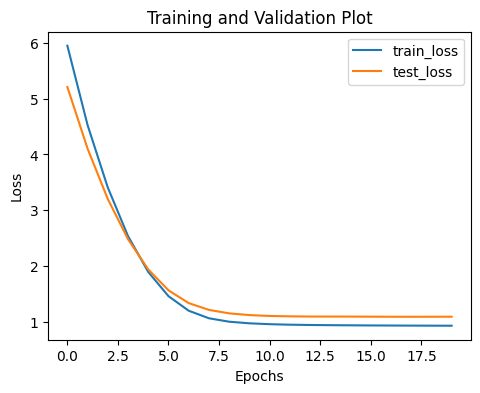

History loaded successfully.
precision@10: 20.86%
recall@10: 4.93%
ndcg@10: 22.68%
hit@10: 65.28%


In [ ]:
training_configs = {
    "optimizer": torch.optim.Adam(e_mf_model.parameters(), lr=1e-3, weight_decay=1e-4),
    "criterion": RMSELoss(),
    "batch_size": 512,
    "num_epochs": 20
}
trainer = PyTorchTrainer(training_configs, device, e_evaluator, e_early_stopping)
e_mf_rec = MFRecommender(e_dataprep, e_mf_model, trainer, e_evaluator)
e_mf_rec_model_path = "/explicit_mf.pth"
e_mf_rec_history_path = "/explicit_mf.json"

if Path(MODEL_INPUT_PATH + e_mf_rec_model_path).exists():
    e_mf_rec.load_model(Path(MODEL_INPUT_PATH + e_mf_rec_model_path))
    e_mf_rec.load_history(Path(HISTORY_INPUT_PATH + e_mf_rec_history_path))
else:
    e_mf_rec.fit()
    e_mf_rec.save_model(Path(MODEL_OUTPUT_PATH + e_mf_rec_model_path))
    e_mf_rec.save_history(Path(HISTORY_OUTPUT_PATH + e_mf_rec_history_path))

e_mf_rec_eval = e_evaluator.evaluate(e_mf_rec, ['precision', 'recall', 'ndcg', 'hit'], 10)
for key, value in e_mf_rec_eval.items():
    print(f"{key}: {value*100:.2f}%")

Model loaded successfully.


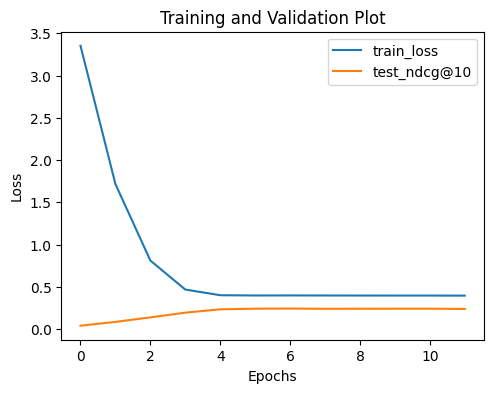

History loaded successfully.
precision@10: 22.46%
recall@10: 4.45%
ndcg@10: 23.90%
hit@10: 66.21%


In [33]:
training_configs = {
    "optimizer": torch.optim.Adam(i_mf_model.parameters(), lr=1e-3, weight_decay=1e-4),
    "criterion": BPRLoss(),
    "batch_size": 512,
    "num_epochs": 20
}
trainer = PyTorchTrainer(training_configs, device, i_evaluator, i_early_stopping)
i_mf_rec = MFRecommender(i_dataprep, i_mf_model, trainer, i_evaluator)
i_mf_rec_model_path = "/implicit_mf.pth"
i_mf_rec_history_path = "/implicit_mf.json"
if Path(MODEL_INPUT_PATH + i_mf_rec_model_path).exists():
    i_mf_rec.load_model(Path(MODEL_INPUT_PATH + i_mf_rec_model_path))
    i_mf_rec.load_history(Path(HISTORY_INPUT_PATH + i_mf_rec_history_path))
else:
    i_mf_rec.fit()
    i_mf_rec.save_model(Path(MODEL_OUTPUT_PATH + i_mf_rec_model_path))
    i_mf_rec.save_history(Path(HISTORY_OUTPUT_PATH + i_mf_rec_history_path))

i_mf_rec_eval = i_evaluator.evaluate(i_mf_rec, ['precision', 'recall', 'ndcg', 'hit'], 10)
for key, value in i_mf_rec_eval.items():
    print(f"{key}: {value*100:.2f}%")

In [34]:
i_knn_rec = ItemKNN(10, 10, i_dataprep)
i_knn_rec_model_path = "/implicit_item_knn.npz"
if Path(MODEL_INPUT_PATH+i_knn_rec_model_path).exists():
    i_knn_rec.load_model(Path(MODEL_INPUT_PATH+i_knn_rec_model_path))
else:
    i_knn_rec.fit()
    i_knn_rec.save(Path(MODEL_OUTPUT_PATH+i_knn_rec_model_path))
    
i_knn_rec_eval = i_evaluator.evaluate(i_knn_rec, ['precision', 'recall', 'ndcg', 'hit'], 10)
for key, value in i_knn_rec_eval.items():
    print(f"{key}: {value*100:.2f}%")

Model loaded successfully.
precision@10: 23.01%
recall@10: 4.46%
ndcg@10: 24.57%
hit@10: 63.32%


Model loaded successfully.


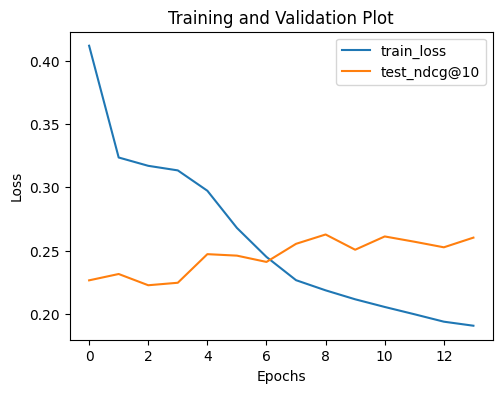

History loaded successfully.
precision@10: 23.95%
recall@10: 5.59%
ndcg@10: 26.02%
hit@10: 70.81%


In [35]:
training_configs = {
    "optimizer": torch.optim.Adam(i_neumf_model.parameters(), lr=1e-3, weight_decay=1e-4),
    "criterion": BPRLoss(),
    "batch_size": 512,
    "num_epochs": 20
}
i_early_stopping = EarlyStopping(inverse=False)
trainer = PyTorchTrainer(training_configs, device, i_evaluator, i_early_stopping)
i_neumf_rec = NeuMFRecommender(i_dataprep, i_neumf_model, trainer, i_evaluator)
i_neumf_rec_model_path = "/implicit_neumf.pth"
i_neumf_rec_history_path = "/implicit_neumf.json"
if Path(MODEL_INPUT_PATH + i_neumf_rec_model_path).exists():
    i_neumf_rec.load_model(Path(MODEL_INPUT_PATH + i_neumf_rec_model_path))
    i_neumf_rec.load_history(Path(HISTORY_INPUT_PATH + i_neumf_rec_history_path))
else:
    i_neumf_rec.fit()
    i_neumf_rec.save_model(Path(MODEL_OUTPUT_PATH + i_neumf_rec_model_path))
    i_neumf_rec.save_history(Path(HISTORY_OUTPUT_PATH + i_neumf_rec_history_path))

i_neumf_rec_eval = i_evaluator.evaluate(i_neumf_rec, ['precision', 'recall', 'ndcg', 'hit'], 10)
for key, value in i_neumf_rec_eval.items():
    print(f"{key}: {value*100:.2f}%")

Model loaded successfully.


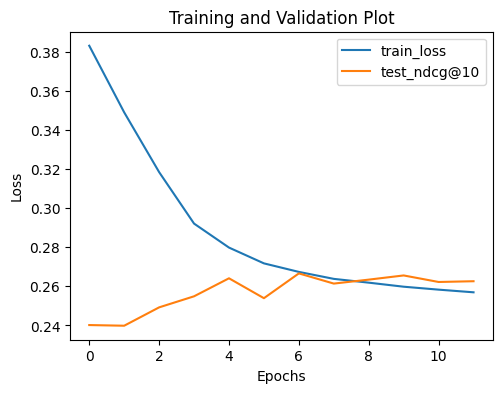

History loaded successfully.
precision@10: 24.56%
recall@10: 5.99%
ndcg@10: 26.66%
hit@10: 70.98%


In [84]:
i_neumf_bce_model = NeuMF(i_dataprep.n_users, i_dataprep.n_items, embedding_dim=30, nums_hiddens=[128, 64, 32])
training_configs = {
    "optimizer": torch.optim.Adam(i_neumf_bce_model.parameters(), lr=1e-3, weight_decay=1e-4),
    "criterion": BCEWithLogitsLoss(),
    "batch_size": 512,
    "num_epochs": 20
}
i_early_stopping = EarlyStopping(inverse=False)
trainer = PyTorchTrainer(training_configs, device, i_evaluator, i_early_stopping)
i_dataprep = DataPreparation(gts_train_df, gts_test_df, "userId", "movieId", "rating", implicit=True, threshold=3.0)
i_neumf_bce_rec = NeuMFRecommender(i_dataprep, i_neumf_bce_model, trainer, i_evaluator)
i_neumf_bce_rec_model_path = "/implicit_neumf_bce.pth"
i_neumf_bce_rec_history_path = "/implicit_neumf_bce.json"
if Path(MODEL_INPUT_PATH + i_neumf_bce_rec_model_path).exists():
    i_neumf_bce_rec.load_model(Path(MODEL_INPUT_PATH + i_neumf_bce_rec_model_path))
    i_neumf_bce_rec.load_history(Path(HISTORY_INPUT_PATH + i_neumf_bce_rec_history_path))
else:
    i_neumf_bce_rec.fit()
    i_neumf_bce_rec.save_model(Path(MODEL_OUTPUT_PATH + i_neumf_bce_rec_model_path))
    i_neumf_bce_rec.save_history(Path(HISTORY_OUTPUT_PATH + i_neumf_bce_rec_history_path))

i_neumf_bce_rec_eval = i_evaluator.evaluate(i_neumf_bce_rec, ['precision', 'recall', 'ndcg', 'hit'], 10)
for key, value in i_neumf_bce_rec_eval.items():
    print(f"{key}: {value*100:.2f}%")

Evaluating ItemKNN...
Evaluating NeuMF...


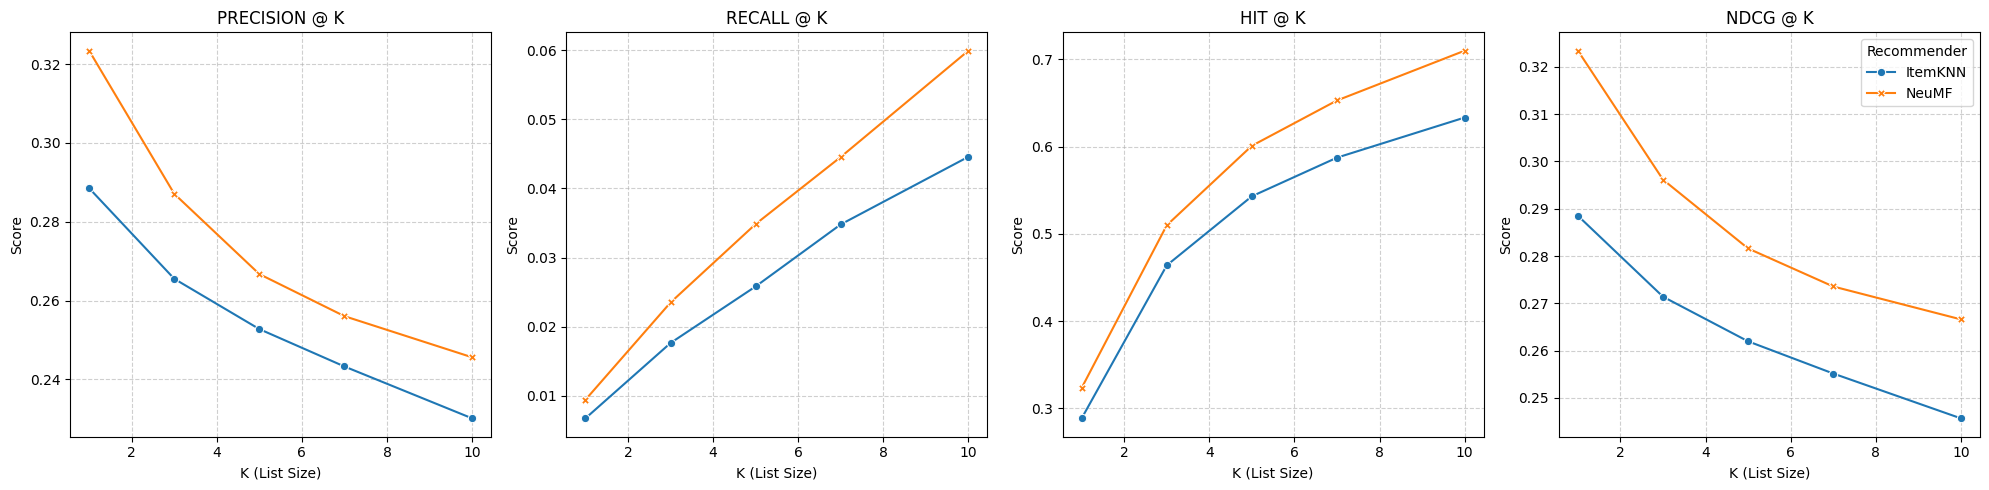

In [ ]:
import seaborn as sns

def get_scores_for_k(recommender, top_k_list, metrics, evaluator):
    """
    Evaluates a single recommender for every k in top_k_list.
    Returns a list of records: [{'k': 5, 'Metric': 'precision', 'Score': 0.1}, ...]
    """
    results = []
    for k in top_k_list:
        scores_at_k = evaluator.evaluate(recommender, metrics=metrics, k=k)
        for key, score in scores_at_k.items():
            metric_name = key.split('@')[0]
            results.append({
                'k': k,
                'Metric': metric_name,
                'Score': score
            })
            
    return results

def plot_top_k_performance(recommenders_dict, top_k_list, evaluator, metrics=None):
    if metrics is None:
        metrics = ['precision', 'recall', 'hit', 'ndcg']
        
    all_data = []
    for name, recommender in recommenders_dict.items():
        print(f"Evaluating {name}...")
        rec_results = get_scores_for_k(recommender, top_k_list, metrics, evaluator)
        
        for row in rec_results:
            row['Recommender'] = name
            all_data.append(row)
            
    df = pd.DataFrame(all_data)

    num_metrics = len(metrics)
    fig, axes = plt.subplots(1, num_metrics, figsize=(5 * num_metrics, 5))
    
    # Handle case where there is only 1 metric (axes is not a list)
    if num_metrics == 1:
        axes = [axes]
    
    for ax, metric in zip(axes, metrics):
        metric_df = df[df['Metric'] == metric]
        
        sns.lineplot(
            data=metric_df,
            x='k',
            y='Score',
            hue='Recommender',    # Different color for each model
            style='Recommender',  # Different line style for each model
            markers=True,         # Show dots at data points
            dashes=False,         # Solid lines
            ax=ax
        )
        
        ax.set_title(f'{metric.upper()} @ K')
        ax.set_xlabel('K (List Size)')
        ax.set_ylabel('Score')
        ax.grid(True, linestyle='--', alpha=0.6)
        
        # Only show legend on the last plot to save space
        if metric != metrics[-1]:
            ax.get_legend().remove()
            
    plt.tight_layout()
    plt.show()
    
    return df


recommenders_to_test = {
    "ItemKNN": i_knn_rec,
    "NeuMF": i_neumf_rec
}

k_list = [1, 3, 5, 7, 10]

perf_df = plot_top_k_performance(recommenders_to_test, k_list, i_evaluator)

## 3.F. Item-POP

# 5. Defining Pipeline

# 6. Experimentations

## 6.A. How do different splitting strategies affect explicit MF's model performance?

## 6.B. Does implicit MF with pairwise loss performs better than explicit MF?

## 6.C. How does NCF perform compared to previous models and baselines?

## 6.D. How does Sequence-Aware RecSys perform compared to previous models and baselines?